In [ ]:
# default_exp modeling.core


In [ ]:
# all_slow



In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling.core

> This module contains core custom models, loss functions, and a default layer group splitter for use in applying discriminiative learning rates to your Hugging Face models trained via fastai

In [ ]:
# export
import os, inspect
from typing import Any, Callable, Dict, List, Optional, Union, Type

from fastcore.all import *
from fastai.callback.all import *
from fastai.data.block import DataBlock, ColReader, CategoryBlock, MultiCategoryBlock, ColSplitter, RandomSplitter
from fastai.data.core import DataLoader, DataLoaders, TfmdDL
from fastai.imports import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.metrics import accuracy, F1Score, accuracy_multi, F1ScoreMulti
from fastai.torch_core import *
from fastai.torch_imports import *
from fastprogress.fastprogress import progress_bar, master_bar
from transformers import AutoModelForSequenceClassification, logging, PretrainedConfig, PreTrainedTokenizerBase, PreTrainedModel

from blurr.utils import BLURR, set_seed
from blurr.data.core import HF_TextBlock, HF_BaseInput, first_blurr_tfm

logging.set_verbosity_error()


In [ ]:
# hide_input
import pdb

from fastai.data.external import untar_data, URLs
from fastcore.test import *
from nbverbose.showdoc import show_doc

from blurr.utils import print_versions
from blurr.data.core import BlurrDataLoader

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")


What we're running with at the time this documentation was generated:
torch: 1.7.1
fastai: 2.5.3
transformers: 4.13.0


In [ ]:
# hide
# cuda
torch.cuda.set_device(1)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")


Using GPU #1: GeForce GTX 1080 Ti


## Base splitter, model wrapper, and model callback

In [ ]:
# export
def hf_splitter(m: Module):
    """Splits the Hugging Face model based on various model architecture conventions"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    top_module_name, top_module = root_modules[0]

    groups = L([m for m_name, m in list(top_module.named_children())])
    groups += L([m for m_name, m in root_modules[1:]])

    return groups.map(params).filter(lambda el: len(el) > 0)


In [ ]:
show_doc(hf_splitter)


<h4 id="hf_splitter" class="doc_header"><code>hf_splitter</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>hf_splitter</code>(**`m`**:`Module`)

Splits the Hugging Face model based on various model architecture conventions

**Parameters:**


 - **`m`** : *`<class 'fastai.torch_core.Module'>`*


In [ ]:
# export
class HF_BaseModelWrapper(Module):
    def __init__(
        self,
        # Your Hugging Face model
        hf_model: PreTrainedModel,
        # If True, hidden_states will be returned and accessed from Learner
        output_hidden_states: bool = False,
        # If True, attentions will be returned and accessed from Learner
        output_attentions: bool = False,
        # Any additional keyword arguments you want passed into your models forward method
        hf_model_kwargs={},
    ):
        super().__init__()

        store_attr(self=self, names="output_hidden_states, output_attentions, hf_model_kwargs")
        self.hf_model = hf_model.cuda() if torch.cuda.is_available() else hf_model

        self.hf_model_fwd_args = list(inspect.signature(self.hf_model.forward).parameters.keys())

    def forward(self, x):
        for k in list(x):
            if k not in self.hf_model_fwd_args:
                del x[k]

        return self.hf_model(
            **x,
            output_hidden_states=self.output_hidden_states,
            output_attentions=self.output_attentions,
            return_dict=True,
            **self.hf_model_kwargs
        )



Note that `HF_BaseModelWrapper` includes some nifty code for just passing in the things your model needs, as not all transformer architectures require/use the same information.

In [ ]:
# export
class HF_PreCalculatedLoss:
    def __call__(self, inp, targ, **kwargs):
        return tensor(0.0)

    def decodes(self, x):
        return x.argmax(dim=-1)

    def activation(self, x):
        return F.softmax(x, dim=-1)



If you want to let your Hugging Face model calculate the loss for you, make sure you include the `labels` argument in your inputs and use `HF_PreCalculatedLoss` as your loss function. Even though we don't really need a loss function per se, we have to provide a custom loss class/function for fastai to function properly (e.g. one with a `decodes` and `activation` methods).  Why?  Because these methods will get called in methods like `show_results` to get the actual predictions.

In [ ]:
# export
class HF_BaseModelCallback(Callback):
    def before_batch(self):
        self.hf_loss = None

    def after_pred(self):
        model_outputs = self.pred
        self.learn.blurr_model_outputs = {}

        for k, v in model_outputs.items():
            # if the "labels" are included, we are training with target labels in which case the loss is returned
            if k == "loss" and isinstance(self.learn.loss_func, HF_PreCalculatedLoss):
                self.hf_loss = to_float(v)
            # the logits represent the prediction
            elif k == "logits":
                self.learn.pred = v
            # add any other things included in model_outputs as blurr_{model_output_key}
            else:
                self.learn.blurr_model_outputs[k] = v

    def after_loss(self):
        # if we already have the loss from the model, update the Learner's loss to be it
        if self.hf_loss is not None:
            self.learn.loss_grad = self.hf_loss
            self.learn.loss = self.learn.loss_grad.clone()


We use a `Callback` for handling what is returned from the Hugging Face model. The return type is (`ModelOutput`)[https://huggingface.co/transformers/main_classes/output.html#transformers.file_utils.ModelOutput] which makes it easy to return all the goodies we asked for.

Note that your `Learner`'s loss will be set for you only if the Hugging Face model returns one *and* you are using the `HF_PreCalculatedLoss` loss function.  

Also note that anything else you asked the model to return (for example, last hidden state, etc..) will be available for you via the `blurr_model_outputs` property attached to your `Learner`. For example, assuming you are using BERT for a classification task ... if you have told your `HF_BaseModelWrapper` instance to return attentions, you'd be able to access them via `learn.blurr_model_outputs['attentions']`.

## Sequence classification

Below demonstrates how to setup your `blurr` pipeline for a sequence classification task (e.g., a model that requires a single text input) using the mid, high, and low-level API

### Using the mid-level API

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)
imdb_df = pd.read_csv(path / "texts.csv")



In [ ]:
imdb_df.head()


,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


In [ ]:
# hide_output
model_cls = AutoModelForSequenceClassification

pretrained_model_name = "distilroberta-base"  # "distilbert-base-uncased" "bert-base-uncased"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=model_cls)


In [ ]:
# single input
set_seed()
blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), CategoryBlock)
dblock = DataBlock(blocks=blocks, get_x=ColReader("text"), get_y=ColReader("label"), splitter=RandomSplitter(seed=42))



In [ ]:
# hide
# dblock.summary(imdb_df)


In [ ]:
dls = dblock.dataloaders(imdb_df, bs=4)


In [ ]:
# dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)


#### Training

We'll also add in custom summary methods for blurr learners/models that work with dictionary inputs

In [ ]:
set_seed()

model = HF_BaseModelWrapper(hf_model)
learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[HF_BaseModelCallback],
    splitter=hf_splitter,
)

learn.freeze()


`.to_fp16()` requires a GPU so had to remove for tests to run on github.  Let's check that we can get predictions.

In [ ]:
# hide_output
# learn.summary()


In [ ]:
# print(len(learn.opt.param_groups))


In [ ]:
# learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])


In [ ]:
set_seed()
learn.fit_one_cycle(1, lr_max=1e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.331639,0.291935,0.880000,00:11


epoch	train_loss	valid_loss	accuracy	time
0	0.324516	0.294210	0.885000	00:11

#### Showing results

And here we create a @typedispatched implementation of `Learner.show_results`.

In [ ]:
# export
@typedispatch
def show_results(
    # This typedispatched `show_results` will be called for `HF_BaseInput` typed inputs
    x: HF_BaseInput,
    # Your targets
    y,
    # Your raw inputs/targets
    samples,
    # The model's predictions
    outs,
    # Your `Learner`. This is required so as to get at the Hugging Face objects for decoding them into
    # something understandable
    learner,
    # Your `show_results` context
    ctxs=None,
    # The maximum number of items to show
    max_n=6,
    # Any truncation your want applied to your decoded inputs
    trunc_at=None,
    # Any other keyword arguments you want applied to `show_results`
    **kwargs,
):
    # grab our tokenizer
    tfm = first_blurr_tfm(learner.dls)
    hf_tokenizer = tfm.hf_tokenizer

    trg_labels = None
    if hasattr(learner.dls, "label_names"):
        trg_labels = learner.dls.label_names

    res = L()
    n_inp = learner.dls.n_inp

    for idx, (input_ids, label, pred, sample) in enumerate(zip(x, y, outs, samples)):
        if idx >= max_n:
            break

        # add in the input text
        rets = [hf_tokenizer.decode(input_ids, skip_special_tokens=True)[:trunc_at]]
        # add in the targets
        for item in sample[n_inp:]:
            if not torch.is_tensor(item):
                trg = item
            elif is_listy(item.tolist()):
                trg = [trg_labels[idx] for idx, val in enumerate(label.numpy().tolist()) if (val == 1)] if (trg_labels) else label.item()
            else:
                trg = trg_labels[label.item()] if (trg_labels) else label.item()

            rets.append(trg)
        # add in the predictions
        for item in pred:
            if not torch.is_tensor(item):
                p = item
            elif is_listy(item.tolist()):
                p = [trg_labels[idx] for idx, val in enumerate(item.numpy().tolist()) if (val == 1)] if (trg_labels) else item.item()
            else:
                p = trg_labels[item.item()] if (trg_labels) else item.item()

            rets.append(p)

        res.append(tuplify(rets))

    cols = ["text"] + ["target" if (i == 0) else f"target_{i}" for i in range(len(res[0]) - n_inp * 2)]
    cols += ["prediction" if (i == 0) else f"prediction_{i}" for i in range(len(res[0]) - n_inp * 2)]
    display_df(pd.DataFrame(res, columns=cols)[:max_n])
    return ctxs


In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)


,text,target,prediction
0,"Many neglect that this isn't just a classic due to the fact that it's the first 3D game, or even the first shoot-'em-up. It's also one of the first stealth games, one of the only(and definitely the first) truly claustrophobic games, and just a pretty well-rounded gaming experience in general. With graphics that are terribly dated today, the game thrusts you into the role of B.J.(don't even *think* I'm going to attempt spelling his last name!), an American P.O.W. caught in an underground bunker.",positive,positive
1,"Well, what can I say.<br /><br />""What the Bleep do we Know"" has achieved the nearly impossible - leaving behind such masterpieces of the genre as ""The Postman"", ""The Dungeon Master"", ""Merlin"", and so fourth, it will go down in history as the single worst movie I have ever seen in its entirety. And that, ladies and gentlemen, is impressive indeed, for I have seen many a bad movie.<br /><br />This masterpiece of modern cinema consists of two interwoven parts, alternating between a silly and cont",negative,negative


In [ ]:
# export
@patch
def blurr_predict(self: Learner, items, rm_type_tfms=None):
    # grab our blurr tfm with the bits to properly decode/show our inputs/targets
    tfm = first_blurr_tfm(self.dls)

    is_split_str = tfm.is_split_into_words and isinstance(items[0], str)
    is_df = isinstance(items, pd.DataFrame)

    if not is_df and (is_split_str or not is_listy(items)):
        items = [items]
    dl = self.dls.test_dl(items, rm_type_tfms=rm_type_tfms, num_workers=0)

    with self.no_bar():
        probs, _, decoded_preds = self.get_preds(dl=dl, with_input=False, with_decoded=True)

    trg_tfms = self.dls.tfms[self.dls.n_inp :]

    outs = []
    probs, decoded_preds = L(probs), L(decoded_preds)
    for i in range(len(items)):
        item_probs = probs.itemgot(i)
        item_dec_preds = decoded_preds.itemgot(i)
        item_dec_labels = tuplify([tfm.decode(item_dec_preds[tfm_idx]) for tfm_idx, tfm in enumerate(trg_tfms)])

        outs.append((item_dec_labels, item_dec_preds, item_probs))

    return outs


In [ ]:
show_doc(Learner.blurr_predict)


<h4 id="Learner.blurr_predict" class="doc_header"><code>Learner.blurr_predict</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.blurr_predict</code>(**`items`**, **`rm_type_tfms`**=*`None`*)



**Parameters:**


 - **`items`** : *`<class 'inspect._empty'>`*

 - **`rm_type_tfms`** : *`<class 'NoneType'>`*, *optional*


We need to replace fastai's `Learner.predict` method with the one above which is able to work with inputs that are represented by multiple tensors included in a dictionary.

In [ ]:
learn.blurr_predict("I really liked the movie")



[(('positive',), (#1) [tensor(1)], (#1) [tensor([0.0733, 0.9267])])]

In [ ]:
learn.blurr_predict(["I really liked the movie", "I really hated the movie"])



[(('positive',), (#1) [tensor(1)], (#1) [tensor([0.0733, 0.9267])]),
 (('negative',), (#1) [tensor(0)], (#1) [tensor([0.6534, 0.3466])])]

Though not useful in sequence classification, we will also add a `blurr_generate` method to `Learner` that uses Hugging Face's `PreTrainedModel.generate` for text generation tasks.  

For the full list of arguments you can pass in see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate). You can also check out their ["How To Generate"](https://github.com/huggingface/blog/blob/master/notebooks/02_how_to_generate.ipynb) notebook for more information about how it all works.

In [ ]:
# export
@patch
def blurr_generate(self: Learner, inp, **kwargs):
    """Uses the built-in `generate` method to generate the text 
    (see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
    for a list of arguments you can pass in)
    """
    # grab our blurr tfm with the bits to properly decode/show our inputs/targets
    tfm = first_blurr_tfm(self.dls)

    # grab the Hugging Face tokenizer from the learner's dls.tfms
    hf_config = tfm.hf_config
    hf_tokenizer = tfm.hf_tokenizer
    tok_kwargs = tfm.tok_kwargs

    # grab the text generation kwargs
    text_gen_kwargs = tfm.text_gen_kwargs if (len(kwargs) == 0) else kwargs

    if isinstance(inp, str):
        input_ids = hf_tokenizer.encode(inp, padding=True, truncation=True, return_tensors="pt", **tok_kwargs)
    else:
        # note (10/30/2020): as of pytorch 1.7, this has to be a plain ol tensor (not a subclass of TensorBase)
        input_ids = inp.as_subclass(Tensor)

    input_ids = input_ids.to(self.model.hf_model.device)

    gen_texts = self.model.hf_model.generate(input_ids, **text_gen_kwargs)
    outputs = [hf_tokenizer.decode(txt, skip_special_tokens=True, clean_up_tokenization_spaces=False) for txt in gen_texts]

    if tfm.hf_arch == "pegasus":
        outputs = [o.replace("<n>", " ") for o in outputs]

    return outputs


In [ ]:
show_doc(Learner.blurr_generate)


<h4 id="Learner.blurr_generate" class="doc_header"><code>Learner.blurr_generate</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.blurr_generate</code>(**`inp`**, **\*\*`kwargs`**)

Uses the built-in `generate` method to generate the text 
(see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
for a list of arguments you can pass in)

**Parameters:**


 - **`inp`** : *`<class 'inspect._empty'>`*

 - **`kwargs`** : *`<class 'inspect._empty'>`*


In [ ]:
learn.unfreeze()


In [ ]:
set_seed()
learn.fit_one_cycle(2, lr_max=slice(1e-7, 1e-4))


epoch,train_loss,valid_loss,accuracy,time
0,0.280282,0.267707,0.890000,00:18
1,0.216157,0.260813,0.895000,00:17


epoch	train_loss	valid_loss	accuracy	time
0	0.263290	0.272322	0.895000	00:18
1	0.218568	0.263317	0.910000	00:18

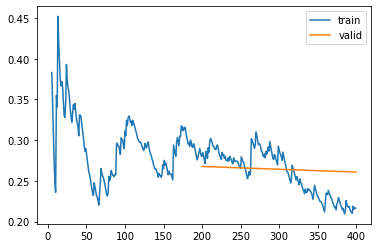

In [ ]:
learn.recorder.plot_loss()


In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)


,text,target,prediction
0,"Many neglect that this isn't just a classic due to the fact that it's the first 3D game, or even the first shoot-'em-up. It's also one of the first stealth games, one of the only(and definitely the first) truly claustrophobic games, and just a pretty well-rounded gaming experience in general. With graphics that are terribly dated today, the game thrusts you into the role of B.J.(don't even *think* I'm going to attempt spelling his last name!), an American P.O.W. caught in an underground bunker.",positive,positive
1,"Well, what can I say.<br /><br />""What the Bleep do we Know"" has achieved the nearly impossible - leaving behind such masterpieces of the genre as ""The Postman"", ""The Dungeon Master"", ""Merlin"", and so fourth, it will go down in history as the single worst movie I have ever seen in its entirety. And that, ladies and gentlemen, is impressive indeed, for I have seen many a bad movie.<br /><br />This masterpiece of modern cinema consists of two interwoven parts, alternating between a silly and cont",negative,negative


In [ ]:
learn.blurr_predict("This was a really good movie")


[(('positive',), (#1) [tensor(1)], (#1) [tensor([0.1502, 0.8498])])]

In [ ]:
learn.blurr_predict("Acting was so bad it was almost funny.")


[(('negative',), (#1) [tensor(0)], (#1) [tensor([0.8028, 0.1972])])]

#### Inference

In [ ]:
export_fname = "seq_class_learn_export"



#### Using fast.ai `Learner.export` and `load_learner`

In [ ]:
learn.export(fname=f"{export_fname}.pkl")


In [ ]:
inf_learn = load_learner(fname=f"{export_fname}.pkl")
inf_learn.blurr_predict("This movie should not be seen by anyone!!!!")


[(('negative',), (#1) [tensor(0)], (#1) [tensor([0.9271, 0.0729])])]

In [ ]:
# hide
try:
    del learn
    del inf_learn
    torch.cuda.empty_cache()
except:
    pass


### Using the high-level API

#### Blearner

Instead of constructing our low-level `Learner`, we can use the `Blearner` class which provides sensible defaults for training

In [ ]:
# hide_output
model_cls = AutoModelForSequenceClassification

pretrained_model_name = "distilroberta-base"  # "distilbert-base-uncased" "bert-base-uncased"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=model_cls)

dls = dblock.dataloaders(imdb_df, bs=4)


In [ ]:
# export
@delegates(Learner.__init__)
class Blearner(Learner):
    def __init__(
        self,
        # Your fast.ai DataLoaders
        dls: DataLoaders,
        # Your pretrained Hugging Face transformer
        hf_model: PreTrainedModel,
        # Your `HF_BaseModelCallback`
        base_model_cb: HF_BaseModelCallback = HF_BaseModelCallback,
        # Any kwargs you want to pass to your `BLearner`
        **kwargs
    ):
        model = kwargs.get("model", HF_BaseModelWrapper(hf_model))
        loss_func = kwargs.pop("loss_func", dls.loss_func if hasattr(dls, "loss_func") else None)
        splitter = kwargs.pop("splitter", hf_splitter)

        super().__init__(dls, model=model, loss_func=loss_func, splitter=splitter, **kwargs)

        self.add_cb(base_model_cb)
        self.freeze()


In [ ]:
learn = Blearner(dls, hf_model, metrics=[accuracy])


In [ ]:
learn.fit_one_cycle(1, lr_max=1e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.407615,0.291459,0.905000,00:12


In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)


,text,target,prediction
0,"Many neglect that this isn't just a classic due to the fact that it's the first 3D game, or even the first shoot-'em-up. It's also one of the first stealth games, one of the only(and definitely the first) truly claustrophobic games, and just a pretty well-rounded gaming experience in general. With graphics that are terribly dated today, the game thrusts you into the role of B.J.(don't even *think* I'm going to attempt spelling his last name!), an American P.O.W. caught in an underground bunker.",positive,positive
1,"Well, what can I say.<br /><br />""What the Bleep do we Know"" has achieved the nearly impossible - leaving behind such masterpieces of the genre as ""The Postman"", ""The Dungeon Master"", ""Merlin"", and so fourth, it will go down in history as the single worst movie I have ever seen in its entirety. And that, ladies and gentlemen, is impressive indeed, for I have seen many a bad movie.<br /><br />This masterpiece of modern cinema consists of two interwoven parts, alternating between a silly and cont",negative,negative


In [ ]:
learn.blurr_predict("This was a really good movie")


[(('positive',), (#1) [tensor(1)], (#1) [tensor([0.1866, 0.8134])])]

In [ ]:
learn.export(fname=f"{export_fname}.pkl")
inf_learn = load_learner(fname=f"{export_fname}.pkl")
inf_learn.blurr_predict("This movie should not be seen by anyone!!!!")


[(('negative',), (#1) [tensor(0)], (#1) [tensor([0.8549, 0.1451])])]

#### BlearnerForSequenceClassification

We also introduce a task specific `Blearner` that get you your DataBlock, DataLoaders, and BLearner in one line of code!

In [ ]:
# hide
try:
    del learn
    del inf_learn
    torch.cuda.empty_cache()
except:
    pass



In [ ]:
# export
@delegates(Blearner.__init__)
class BlearnerForSequenceClassification(Blearner):
    def __init__(self, dls: DataLoaders, hf_model: PreTrainedModel, **kwargs):
        super().__init__(dls, hf_model, **kwargs)

    @classmethod
    def get_model_cls(self):
        return AutoModelForSequenceClassification

    @classmethod
    def _get_x(cls, r, attr):
        return r[attr] if (isinstance(attr, str)) else tuple(r[inp] for inp in attr)

    @classmethod
    def _get_y(cls, r, attr):
        return r[attr] if (isinstance(attr, str)) else [r[inp] for inp in attr]

    @classmethod
    def _create_learner(
        cls,
        # Your raw dataset
        data,
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path: Optional[Union[str, os.PathLike]],
        # A function to perform any preprocessing required for your Dataset
        preprocess_func: Callable = None,
        # The attribute in your dataset that contains your raw text
        text_attr: str = "text",
        # The attribute in your dataset that contains your labels/targets
        label_attr: str = "label",
        # The number of labels/classes your model should predict
        n_labels: int = 2,
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter: Callable = RandomSplitter(),
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs={},
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs={},
    ):
        # get our hf objects
        hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(
            pretrained_model_name_or_path, model_cls=cls.get_model_cls(), config_kwargs={"num_labels": n_labels}
        )

        # if we need to preprocess the raw data before creating our DataLoaders
        if preprocess_func:
            data = preprocess_func(data, hf_arch, hf_config, hf_tokenizer, hf_model, text_attr, label_attr)

        # not all architectures include a native pad_token (e.g., gpt2, ctrl, etc...), so we add one here
        if hf_tokenizer.pad_token is None:
            hf_tokenizer.add_special_tokens({"pad_token": "<pad>"})
            hf_config.pad_token_id = hf_tokenizer.get_vocab()["<pad>"]
            hf_model.resize_token_embeddings(len(hf_tokenizer))

        # defin our input/target getters
        if isinstance(data, pd.DataFrame):
            get_x = ColReader(text_attr)
            get_y = ColReader(label_attr)
        else:
            get_x = partial(cls._get_x, attr=text_attr)
            get_y = partial(cls._get_y, attr=label_attr)

        # infer loss function and default metrics
        if is_listy(label_attr):
            trg_block = MultiCategoryBlock(encoded=True, vocab=label_attr)
            learner_kwargs["metrics"] = learner_kwargs.get("metrics", [F1ScoreMulti(), accuracy_multi])
        else:
            trg_block = CategoryBlock
            learner_kwargs["metrics"] = learner_kwargs.get("metrics", [F1Score(), accuracy])

        # build our DataBlock and DataLoaders
        blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), trg_block)
        dblock = DataBlock(blocks=blocks, get_x=get_x, get_y=get_y, splitter=dblock_splitter)

        dls = dblock.dataloaders(data, **dl_kwargs.copy())

        # return BLearner instance
        return cls(dls, hf_model, **learner_kwargs.copy())

    @classmethod
    def from_dataframe(
        cls,
        # Your pandas DataFrame
        df: pd.DataFrame,
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path: Optional[Union[str, os.PathLike]],
        # A function to perform any preprocessing required for your Dataset
        preprocess_func: Callable = None,
        # The attribute in your dataset that contains your raw text
        text_attr: str = "text",
        # The attribute in your dataset that contains your labels/targets
        label_attr: str = "label",
        # The number of labels/classes your model should predict
        n_labels: int = None,
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter: Callable = ColSplitter(),
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs={},
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs={},
    ):
        # we need to tell transformer how many labels/classes to expect
        if n_labels is None:
            n_labels = len(label_attr) if (is_listy(label_attr)) else len(df[label_attr].unique())

        return cls._create_learner(
            df, pretrained_model_name_or_path, preprocess_func, text_attr, label_attr, n_labels, dblock_splitter, dl_kwargs, learner_kwargs
        )

    @classmethod
    def from_csv(
        cls,
        # The path to your csv file
        csv_file: Union[Path, str],
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path: Optional[Union[str, os.PathLike]],
        # A function to perform any preprocessing required for your Dataset
        preprocess_func: Callable = None,
        # The attribute in your dataset that contains your raw text
        text_attr: str = "text",
        # The attribute in your dataset that contains your labels/targets
        label_attr: str = "label",
        # The number of labels/classes your model should predict
        n_labels: int = None,
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter: Callable = ColSplitter(),
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs={},
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs={},
    ):
        df = pd.read_csv(csv_file)

        return cls.from_dataframe(
            df,
            pretrained_model_name_or_path=pretrained_model_name_or_path,
            preprocess_func=preprocess_func,
            text_attr=text_attr,
            label_attr=label_attr,
            n_labels=n_labels,
            dblock_splitter=dblock_splitter,
            dl_kwargs=dl_kwargs,
            learner_kwargs=learner_kwargs,
        )

    @classmethod
    def from_dictionaries(
        cls,
        # A list of dictionaries
        ds: List[Dict],
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path: Optional[Union[str, os.PathLike]],
        # A function to perform any preprocessing required for your Dataset
        preprocess_func: Callable = None,
        # The attribute in your dataset that contains your raw text
        text_attr: str = "text",
        # The attribute in your dataset that contains your labels/targets
        label_attr: str = "label",
        # The number of labels/classes your model should predict
        n_labels: int = None,
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter: Callable = RandomSplitter(),
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs={},
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs={},
    ):
        # we need to tell transformer how many labels/classes to expect
        if n_labels is None:
            n_labels = len(label_attr) if (is_listy(label_attr)) else len(set([item[label_attr] for item in ds]))

        return cls._create_learner(
            ds, pretrained_model_name_or_path, preprocess_func, text_attr, label_attr, n_labels, dblock_splitter, dl_kwargs, learner_kwargs
        )



In [ ]:
learn = BlearnerForSequenceClassification.from_dataframe(
    imdb_df, "distilroberta-base", text_attr="text", label_attr="label", dl_kwargs={"bs": 4}
)



In [ ]:
learn.fit_one_cycle(1, lr_max=1e-3)


epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.388212,0.328915,0.852071,0.875000,00:12


In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)


,text,target,prediction
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the book is like watching a magnificent ballet with great music, sets, and costumes yet performed by barnyard animals dressed in those costumesso far from Japanese ways of thinking were the characters.<br /><br />The movie isn't about Japan or real geisha. It is a story about a few American men's mistaken ideas about Japan and geish",negative,negative
1,"<br /><br />I'm sure things didn't exactly go the same way in the real life of Homer Hickam as they did in the film adaptation of his book, Rocket Boys, but the movie ""October Sky"" (an anagram of the book's title) is good enough to stand alone. I have not read Hickam's memoirs, but I am still able to enjoy and understand their film adaptation. The film, directed by Joe Johnston and written by Lewis Colick, records the story of teenager Homer Hickam (Jake Gyllenhaal), beginning in October of 195",positive,positive


In [ ]:
learn.blurr_predict("This was a really good movie")


[(('positive',), (#1) [tensor(1)], (#1) [tensor([0.3574, 0.6426])])]

In [ ]:
learn.export(fname=f"{export_fname}.pkl")
inf_learn = load_learner(fname=f"{export_fname}.pkl")
inf_learn.blurr_predict("This movie should not be seen by anyone!!!!")


[(('negative',), (#1) [tensor(0)], (#1) [tensor([0.8701, 0.1299])])]

### Using the low-level API

Thanks to the `BlurrDataLoader`, there isn't really anything you have to do to use plain ol' PyTorch or fast.ai `Dataset`s and `DataLoaders` with Blurr.  Let's take a look at fine-tuning a model against Glue's MRPC dataset ...

In [ ]:
from datasets import load_dataset
from blurr.data.core import preproc_hf_dataset

raw_datasets = load_dataset("glue", "mrpc")


Reusing dataset glue (/home/wgilliam/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


In [ ]:
def tokenize_function(example):
    return hf_tokenizer(example["sentence1"], example["sentence2"], truncation=True)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)


  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
label_names = raw_datasets["train"].features["label"].names

trn_dl = BlurrDataLoader(
    tokenized_datasets["train"],
    hf_arch=hf_arch,
    hf_config=hf_config,
    hf_tokenizer=hf_tokenizer,
    hf_model=hf_model,
    preproccesing_func=preproc_hf_dataset,
    label_names=label_names,
    shuffle=True,
    batch_size=8,
)

val_dl = BlurrDataLoader(
    tokenized_datasets["validation"],
    hf_arch=hf_arch,
    hf_config=hf_config,
    hf_tokenizer=hf_tokenizer,
    hf_model=hf_model,
    preproccesing_func=preproc_hf_dataset,
    label_names=label_names,
    batch_size=16,
)

dls = DataLoaders(trn_dl, val_dl)


And with our fast.ai `DataLoaders` in hand, we can train our model's using the high or low-level Blurr API.  The `BlurrDataLoader` class sets up everything so that we can use our objects just as if we built our `DataLoaders` with the mid-level `DataBlock` API.  This means we get back methods like `one_batch`, `show_batch`, `show_results`, etc... with all levels of Blurr's API.

In [ ]:
learn = BlearnerForSequenceClassification(dls, hf_model, loss_func=CrossEntropyLossFlat())


SuggestedLRs(valley=0.0003311311302240938)

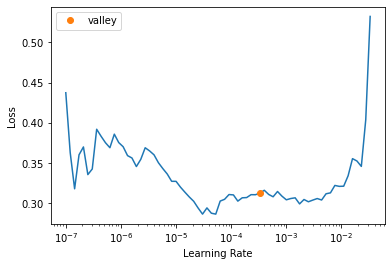

In [ ]:
learn.lr_find()


In [ ]:
learn.fit_one_cycle(1, lr_max=1e-5)


epoch,train_loss,valid_loss,time
0,0.331542,0.351435,00:22


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, lr_max=slice(1e-8, 1e-6))

epoch,train_loss,valid_loss,time
0,0.298948,0.353126,00:26
1,0.319656,0.354693,00:26


In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)


,text,target,prediction
0,"They were being held Sunday in the Camden County Jail on $ 100,000 bail. They remained in Camden County Jail on Sunday on $ 100,000 bail.",equivalent,equivalent
1,"The premium edition adds OfficeFront Page 2003, Acceleration Server 2000, and SQL Server 2000. The premium edition adds ISA Server, SQL Server and a specialized edition of BizTalk 2004.",not_equivalent,not_equivalent


## Tests

The tests below to ensure the core training code above works for **all** pretrained sequence classification models available in Hugging Face.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained classification models you are working with ... and if any of your pretrained sequence classification models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

In [ ]:
# hide
try:
    del learn
    del inf_learn
    torch.cuda.empty_cache()
except:
    pass



In [ ]:
# hide
[model_type for model_type in BLURR.get_models(task="SequenceClassification") if (not model_type.startswith("TF"))]



['AlbertForSequenceClassification',
 'BartForSequenceClassification',
 'BertForSequenceClassification',
 'BigBirdForSequenceClassification',
 'BigBirdPegasusForSequenceClassification',
 'CTRLForSequenceClassification',
 'CamembertForSequenceClassification',
 'CanineForSequenceClassification',
 'ConvBertForSequenceClassification',
 'DebertaForSequenceClassification',
 'DebertaV2ForSequenceClassification',
 'DistilBertForSequenceClassification',
 'ElectraForSequenceClassification',
 'FNetForSequenceClassification',
 'FlaubertForSequenceClassification',
 'FunnelForSequenceClassification',
 'GPT2ForSequenceClassification',
 'GPTJForSequenceClassification',
 'GPTNeoForSequenceClassification',
 'HubertForSequenceClassification',
 'IBertForSequenceClassification',
 'LEDForSequenceClassification',
 'LayoutLMForSequenceClassification',
 'LayoutLMv2ForSequenceClassification',
 'LongformerForSequenceClassification',
 'MBartForSequenceClassification',
 'MPNetForSequenceClassification',
 'MegatronB

In [ ]:
# hide
pretrained_model_names = [
    "albert-base-v1",
    "facebook/bart-base",
    "bert-base-uncased",
    "google/bigbird-roberta-base",
    "sshleifer/tiny-ctrl",
    "camembert-base",
    "sarnikowski/convbert-medium-small-da-cased",
    "microsoft/deberta-base",
    "microsoft/deberta-v2-xlarge",
    "distilbert-base-uncased",
    "monologg/electra-small-finetuned-imdb",
    "flaubert/flaubert_small_cased",
    "huggingface/funnel-small-base",
    "gpt2",
    "kssteven/ibert-roberta-base",
    "allenai/led-base-16384",
    "microsoft/layoutlm-base-uncased",
    "allenai/longformer-base-4096",
    "sshleifer/tiny-mbart",
    "microsoft/mpnet-base",
    "google/mobilebert-uncased",
    "openai-gpt",
    #'reformer-enwik8',                  # (see model card; does not work with/require a tokenizer so no bueno here)
    "roberta-base",
    "squeezebert/squeezebert-uncased",
    #'google/tapas-base',                # (requires pip install torch-scatter)
    "transfo-xl-wt103",
    "xlm-mlm-en-2048",
    "xlm-roberta-base",
    "xlnet-base-cased",
]


In [ ]:
# hide
path = untar_data(URLs.IMDB_SAMPLE)

model_path = Path("models")
imdb_df = pd.read_csv(path / "texts.csv")



In [ ]:
# hide
from transformers import RobertaTokenizer

model_cls = AutoModelForSequenceClassification
bsz = 2
seq_sz = 32

test_results = []
for model_name in pretrained_model_names:
    error = None

    print(f"=== {model_name} ===\n")

    # 1. get/configure our Hugging Face objects
    tok_class = RobertaTokenizer if ("/ibert" in model_name) else None

    hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(
        model_name, model_cls=model_cls, tokenizer_cls=tok_class, config_kwargs={"num_labels": 2}
    )

    print(f"architecture:\t{hf_arch}\ntokenizer:\t{type(hf_tokenizer).__name__}\nmodel:\t\t{type(hf_model).__name__}\n")

    # not all architectures include a native pad_token (e.g., gpt2, ctrl, etc...), so we add one here
    if hf_tokenizer.pad_token is None:
        hf_tokenizer.add_special_tokens({"pad_token": "<pad>"})
        hf_config.pad_token_id = hf_tokenizer.get_vocab()["<pad>"]
        hf_model.resize_token_embeddings(len(hf_tokenizer))

    # 2. get our DataLoaders
    blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model, max_length=seq_sz, padding="max_length"), CategoryBlock)

    dblock = DataBlock(blocks=blocks, get_x=ColReader("text"), get_y=ColReader("label"), splitter=ColSplitter(col="is_valid"))

    dls = dblock.dataloaders(imdb_df, bs=bsz)

    # 3. configure our Learner
    model = HF_BaseModelWrapper(hf_model)
    learn = Learner(
        dls,
        model,
        opt_func=partial(Adam),
        loss_func=CrossEntropyLossFlat(),
        metrics=[accuracy],
        cbs=[HF_BaseModelCallback],
        splitter=hf_splitter,
    )

    learn.freeze()

    b = dls.one_batch()

    # 4. train
    try:
        print("*** TESTING DataLoaders ***")
        test_eq(len(b), bsz)
        test_eq(len(b[0]["input_ids"]), bsz)
        test_eq(b[0]["input_ids"].shape, torch.Size([bsz, seq_sz]))
        test_eq(len(b[1]), bsz)

        #         print('*** TESTING One pass through the model ***')
        #         preds = learn.model(b[0])
        #         test_eq(len(preds[0]), bsz)
        #         test_eq(preds[0].shape, torch.Size([bsz, 2]))

        print("*** TESTING Training/Results ***")
        learn.fit_one_cycle(1, lr_max=1e-3, cbs=ShortEpochCallback(pct=0.2, short_valid=True))

        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, "PASSED", ""))
        learn.show_results(learner=learn, max_n=2, trunc_at=250)
    except Exception as err:
        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, "FAILED", err))
    finally:
        # cleanup
        del learn
        torch.cuda.empty_cache()



=== albert-base-v1 ===

architecture:	albert
tokenizer:	AlbertTokenizerFast
model:		AlbertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"the trouble with the book, ""memoirs of a geisha"" is that it had japanese surfaces but underneath the surfaces it was all",negative,positive
1,"how viewers react to this new ""adaption"" of shirley jackson's book, which was promoted as not being a remake of the original 1963",negative,positive


=== facebook/bart-base ===

architecture:	bart
tokenizer:	BartTokenizerFast
model:		BartForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American",negative,negative
1,<br /><br />I'm sure things didn't exactly go the same way in the real life of Homer Hickam as they did in the,positive,positive


=== bert-base-uncased ===

architecture:	bert
tokenizer:	BertTokenizerFast
model:		BertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"the trouble with the book, "" memoirs of a geisha "" is that it had japanese surfaces but underneath the surfaces it was all an american man '",negative,positive
1,"bonanza had a great cast of wonderful actors. lorne greene, pernell whitaker, michael landon, dan blocker, and even guy williams (",positive,positive


=== google/bigbird-roberta-base ===



normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


architecture:	big_bird
tokenizer:	BigBirdTokenizerFast
model:		BigBirdForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American",negative,negative
1,<br /><br />I'm sure things didn't exactly go the same way in the real life of Homer Hickam as they did in the,positive,positive


=== sshleifer/tiny-ctrl ===



Using pad_token, but it is not set yet.


architecture:	ctrl
tokenizer:	CTRLTokenizer
model:		CTRLForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking. Reading the",negative,negative
1,<br /><br />I'm sure things didn't exactly go the same way in the real life of Homer Hickam as they did in the film adaptation,positive,negative


=== camembert-base ===

architecture:	camembert
tokenizer:	CamembertTokenizerFast
model:		CamembertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the",negative,negative
1,<br /><br />I'm sure things didn't exactly go the same way in the real,positive,negative


=== sarnikowski/convbert-medium-small-da-cased ===

architecture:	convbert
tokenizer:	ConvBertTokenizerFast
model:		ConvBertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"The trouble with the book, "" Memoirs of a Geisha "" is that it had Japanese surfaces but underne",negative,positive
1,< br / > < br / > I'm sure things didn't exactly go the same way in the,positive,positive


=== microsoft/deberta-base ===

architecture:	deberta
tokenizer:	DebertaTokenizerFast
model:		DebertaForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American",negative,negative
1,<br /><br />I'm sure things didn't exactly go the same way in the real life of Homer Hickam as they did in the,positive,negative


=== microsoft/deberta-v2-xlarge ===

architecture:	deberta_v2
tokenizer:	DebertaV2Tokenizer
model:		DebertaV2ForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man",negative,positive
1,<br /><br />I'm sure things didn't exactly go the same way in the real life of Homer Hickam as they did in,positive,positive


=== distilbert-base-uncased ===

architecture:	distilbert
tokenizer:	DistilBertTokenizerFast
model:		DistilBertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"the trouble with the book, "" memoirs of a geisha "" is that it had japanese surfaces but underneath the surfaces it was all an american man '",negative,positive
1,< br / > < br / > i'm sure things didn't exactly go the same way in the real life of homer hickam,positive,positive


=== monologg/electra-small-finetuned-imdb ===

architecture:	electra
tokenizer:	ElectraTokenizerFast
model:		ElectraForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"the trouble with the book, "" memoirs of a geisha "" is that it had japanese surfaces but underneath the surfaces it was all an american man '",negative,negative
1,< br / > < br / > i'm sure things didn't exactly go the same way in the real life of homer hickam,positive,positive


=== flaubert/flaubert_small_cased ===

architecture:	flaubert
tokenizer:	FlaubertTokenizer
model:		FlaubertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"The trouble with the book, "" Memoirs of a Geisha "" is that it had Japanese surfaces but underneath the surfaces it",negative,negative
1,"I couldn' t believe that this movie dates from 2007, it had all the looks of a below-average seventies",negative,negative


=== huggingface/funnel-small-base ===

architecture:	funnel
tokenizer:	FunnelTokenizerFast
model:		FunnelForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"the trouble with the book, "" memoirs of a geisha "" is that it had japanese surfaces but underneath the surfaces it was all an american man '",negative,negative
1,"bonanza had a great cast of wonderful actors. lorne greene, pernell whitaker, michael landon, dan blocker, and even guy williams (",positive,negative


=== gpt2 ===



Using pad_token, but it is not set yet.


architecture:	gpt2
tokenizer:	GPT2TokenizerFast
model:		GPT2ForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's",negative,positive
1,<br /><br />I'm sure things didn't exactly go the same way in the real life of Homer Hickam as they did in the film adaptation,positive,negative


=== kssteven/ibert-roberta-base ===

architecture:	ibert
tokenizer:	RobertaTokenizer
model:		IBertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American",negative,negative
1,"Bonanza had a great cast of wonderful actors. Lorne Greene, Pernell Whitaker, Michael Landon, Dan Blocker, and even",positive,negative


=== allenai/led-base-16384 ===

architecture:	led
tokenizer:	LEDTokenizerFast
model:		LEDForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American",negative,positive
1,<br /><br />I'm sure things didn't exactly go the same way in the real life of Homer Hickam as they did in the,positive,positive


=== microsoft/layoutlm-base-uncased ===

architecture:	layoutlm
tokenizer:	LayoutLMTokenizerFast
model:		LayoutLMForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"the trouble with the book, "" memoirs of a geisha "" is that it had japanese surfaces but underneath the surfaces it was all an american man '",negative,positive
1,"how viewers react to this new "" adaption "" of shirley jackson's book, which was promoted as not being a remake of the original 1963 movie",negative,positive


=== allenai/longformer-base-4096 ===

architecture:	longformer
tokenizer:	LongformerTokenizerFast
model:		LongformerForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American",negative,positive
1,"We saw the silent version of this film, and it is quite simply shimmeringly beautiful. It's quite hard to see how a sound version could have",positive,positive


=== sshleifer/tiny-mbart ===

architecture:	mbart
tokenizer:	MBartTokenizerFast
model:		MBartForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces",negative,negative
1,"I couldn't believe that this movie dates from 2007, it had all the looks of a below-average seventies horror-flick. Did",negative,negative


=== microsoft/mpnet-base ===

architecture:	mpnet
tokenizer:	MPNetTokenizerFast
model:		MPNetForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"the trouble with the book, "" memoirs of a geisha "" is that it had japanese surfaces but underneath the surfaces it was all an american man '",negative,negative
1,"to review this movie, i without any doubt would have to quote that memorable scene in tarantino's "" pulp fiction "" ( 1994 ) when jules",negative,negative


=== google/mobilebert-uncased ===

architecture:	mobilebert
tokenizer:	MobileBertTokenizerFast
model:		MobileBertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"the trouble with the book, "" memoirs of a geisha "" is that it had japanese surfaces but underneath the surfaces it was all an american man '",negative,positive
1,< br / > < br / > i'm sure things didn't exactly go the same way in the real life of homer hickam,positive,positive


=== openai-gpt ===



Using pad_token, but it is not set yet.


architecture:	openai
tokenizer:	OpenAIGPTTokenizerFast
model:		OpenAIGPTForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"the trouble with the book, "" memoirs of a geisha "" is that it had japanese surfaces but underneath the surfaces it was all an american man's",negative,negative
1,"we saw the silent version of this film, and it is quite simply shimmeringly beautiful. it's quite hard to see how a sound version could have",positive,negative


=== roberta-base ===

architecture:	roberta
tokenizer:	RobertaTokenizerFast
model:		RobertaForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American",negative,positive
1,"To review this movie, I without any doubt would have to quote that memorable scene in Tarantino's ""Pulp Fiction"" (1994) when J",negative,positive


=== squeezebert/squeezebert-uncased ===

architecture:	squeezebert
tokenizer:	SqueezeBertTokenizerFast
model:		SqueezeBertForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"the trouble with the book, "" memoirs of a geisha "" is that it had japanese surfaces but underneath the surfaces it was all an american man '",negative,positive
1,"how viewers react to this new "" adaption "" of shirley jackson's book, which was promoted as not being a remake of the original 1963 movie",negative,positive


=== transfo-xl-wt103 ===



/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
Using pad_token, but it is not set yet.


architecture:	transfo_xl
tokenizer:	TransfoXLTokenizer
model:		TransfoXLForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


,text,target,prediction
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all an American man's way of thinking",negative,negative
1,< br / > < br / > I'm sure things didn't exactly go the same way in the real life of Homer Hickam as they did in the film,positive,negative


=== xlm-mlm-en-2048 ===

architecture:	xlm
tokenizer:	XLMTokenizer
model:		XLMForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"the trouble with the book, "" memoirs of a geisha "" is that it had japanese surfaces but underneath the surfaces it was all an american man's",negative,negative
1,"to review this movie, i without any doubt would have to quote that memorable scene in tarantino's "" pulp fiction "" ( 1994 ) when jules",negative,negative


=== xlm-roberta-base ===

architecture:	xlm_roberta
tokenizer:	XLMRobertaTokenizerFast
model:		XLMRobertaForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces",negative,negative
1,<br /><br />I'm sure things didn't exactly go the same way in the real life of Homer Hickam as they,positive,negative


=== xlnet-base-cased ===

architecture:	xlnet
tokenizer:	XLNetTokenizerFast
model:		XLNetForSequenceClassification

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


,text,target,prediction
0,"The trouble with the book, ""Memoirs of a Geisha"" is that it had Japanese surfaces but underneath the surfaces it was all",negative,negative
1,<br /><br />I'm sure things didn't exactly go the same way in the real life of Homer Hick,positive,negative


In [ ]:
# hide_input
test_results_df = pd.DataFrame(test_results, columns=["arch", "tokenizer", "model", "result", "error"])
display_df(test_results_df)


,arch,tokenizer,model,result,error
0,albert,AlbertTokenizerFast,AlbertForSequenceClassification,PASSED,
1,bart,BartTokenizerFast,BartForSequenceClassification,PASSED,
2,bert,BertTokenizerFast,BertForSequenceClassification,PASSED,
3,big_bird,BigBirdTokenizerFast,BigBirdForSequenceClassification,PASSED,
4,ctrl,CTRLTokenizer,CTRLForSequenceClassification,PASSED,
5,camembert,CamembertTokenizerFast,CamembertForSequenceClassification,PASSED,
6,convbert,ConvBertTokenizerFast,ConvBertForSequenceClassification,PASSED,
7,deberta,DebertaTokenizerFast,DebertaForSequenceClassification,PASSED,
8,deberta_v2,DebertaV2Tokenizer,DebertaV2ForSequenceClassification,PASSED,
9,distilbert,DistilBertTokenizerFast,DistilBertForSequenceClassification,PASSED,


## Summary

This module includes the fundamental building blocks for training using Blurr

In [ ]:
# hide
from nbdev.export import notebook2script

notebook2script()


Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01_modeling-core.ipynb.
Converted 02_data-language-modeling.ipynb.
Converted 02_modeling-language-modeling.ipynb.
Converted 03_data-token-classification.ipynb.
Converted 03_modeling-token-classification.ipynb.
Converted 04_data-question-answering.ipynb.
Converted 04_modeling-question-answering.ipynb.
Converted 10_data-seq2seq-core.ipynb.
Converted 10_modeling-seq2seq-core.ipynb.
Converted 11_data-seq2seq-summarization.ipynb.
Converted 11_modeling-seq2seq-summarization.ipynb.
Converted 12_data-seq2seq-translation.ipynb.
Converted 12_modeling-seq2seq-translation.ipynb.
Converted 99a_examples-high-level-api.ipynb.
Converted 99b_examples-glue.ipynb.
Converted 99c_examples-glue-plain-pytorch.ipynb.
Converted 99d_examples-multilabel.ipynb.
Converted 99e_examples-causal-lm-gpt2.ipynb.
Converted index.ipynb.
